# PJM Marginal Fuel Study

Analysis of marginal fuel on PJM over the past decade using public data from PJM and Monitoring Analytics.  We focus particularly on the % of wind and solar offered on the margin and are looking for any growth in these sources relative to fossil as marginal producer.  Study is to support our  effort in helping scope out the size of future curtailed excess generated renewable power available for grid-connected "green" loads. 

Started 1/12/2023 (david.t.wang@atlanticshoreswind.com)
Python 3.9.13 

In [2]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from plotly import graph_objs as go
from plotly import express as px

In [ ]:
# Create array of filenames from PJM website.  These filenames are in the format:
# 202209_Marginal_Fuel_Postings.csv
#
# Data go back to 200401_ ...

filenames = []

for i in np.arange(2004,2024):
    for j in np.arange(1,13):
        filenames.append("%04.0f%02.0f_Marginal_Fuel_Postings.csv" % (i,j))



# 12*(i-2004)+j-1)      '{:4.0f}{:2.0f}'.format)




In [ ]:
# WGET and import monthly PJM data into pandas dataframe
# 
# These files are located at:
# http://www.monitoringanalytics.com/data/marginal_fuel_type/202208_Marginal_Fuel_Postings.csv

urlprefix = 'http://www.monitoringanalytics.com/data/marginal_fuel_type/'
urls = [urlprefix + s for s in filenames]

pjmdat = pd.DataFrame() #([], headers=['RUN','HOUR','MMS_TIMEZONE','FUEL_TYPE','PERCENT_MARGINAL'])

for i in range(len(urls)):
    try:
        tmpdf = pd.read_csv(urls[i])
        pjmdat = pd.concat([pjmdat, tmpdf])
    except:
        print("File %s does not exist." % (filenames[i]))


pjmdat.to_hdf('pjmdat.h5', key='pjmdat')
pjmdat.to_csv('pjmdat.csv')
pjmdat

# CSV files contain: 
# RUN	HOUR	            MMS_TIMEZONE	FUEL_TYPE	PERCENT_MARGINAL
# str   DDMMMYYYY:HH:MM:SS  str             str         %age as str or fraction of 1


In [3]:
# read from saved data to save server call
pjmdat = pd.read_csv('pjmdat.csv', index_col=[0])

# clean duplicate columns and merge to eliminate NaN's
margfueldf = pd.DataFrame() # initalize empty df
margfueldf['DATETIME'] = pjmdat['mms_datetime'].fillna(pjmdat['HOUR']).astype('str')
margfueldf['TIMEZONE'] = pjmdat['MMS_TIMEZONE'].fillna(pjmdat['mms_timezone']).astype('str')
margfueldf['FUEL'] = pjmdat['fuel_type'].fillna(pjmdat['FUEL_TYPE']).astype('str')
margfueldf['PCT_MARGINAL'] = (pjmdat['percent_marginal'].str.replace('%', 'e-2').astype(float)).fillna(pjmdat['PERCENT_MARGINAL'])


C:\Users\DavidTWang\AppData\Local\Temp\ipykernel_32144\844856454.py:2: DtypeWarning: Columns (1,3,4,5,7,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  pjmdat = pd.read_csv('pjmdat.csv', index_col=[0])


In [4]:
# create dtdf, a DST-naive Series of datetimes in EST or EDT
dtdf = pd.to_datetime(margfueldf['DATETIME'], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(margfueldf['DATETIME'], format="%d%b%y:%H:%M:%S", errors="coerce"))

# function to determine whether to correct the nominal UTC times by 1 hour when DST is in effect
def zoneoffsetfunc(pddatetime, tzname):
    adder = {'EST': 0, 'EDT': -1} #dict to match EST/EDT to offset value in hours
    return pddatetime + pd.Timedelta(hours=adder[tzname])

# now add +4 hours to convert to UTC, keeping in mind that times that were in EDT are -1 hour behind
dtdf_UTC = dtdf + pd.Timedelta(hours=4)
tempdf = pd.concat([dtdf_UTC, margfueldf['TIMEZONE']], axis=1)

# apply zoneoffsetfunc to every row in df
tempdf['DATETIME_UTC'] = tempdf.apply(lambda x: zoneoffsetfunc(x['DATETIME'], x['TIMEZONE']), axis=1)

# create naive EST (EDT would be this time +1 hr)
tempdf['DATETIME_ESTn'] = tempdf['DATETIME_UTC'] + pd.Timedelta(hours=-4) 


In [5]:
# put UTC datetime column to margfueldf and drop the original columns
margfueldf['DATETIME_UTC'] = tempdf['DATETIME_UTC']
margfueldf['DATETIME_ESTn'] = tempdf['DATETIME_ESTn']
margfueldf.drop(['DATETIME', 'TIMEZONE'], axis=1, inplace=True)
margfueldf = margfueldf[['DATETIME_ESTn', 'FUEL', 'PCT_MARGINAL']]

In [6]:
# clean up the fuel types by grouping them
tempdf = pd.read_csv('fueltypes_mapping.csv', index_col=[0])
mapping = dict(tempdf[['original','lumped']].values)
margfueldf['FUEL'] = margfueldf['FUEL'].map(mapping)
margfueldf['PCT_MARGINAL'] = margfueldf['PCT_MARGINAL']*100
margfueldf

# set index on datetime
margfueldf.set_index('DATETIME_ESTn', inplace=True)

In [7]:
# reshape df into table with DATETIME as rows and FUEL as columns
# 163374 rows × 16 columns
df = pd.pivot_table(margfueldf.reset_index(), values='PCT_MARGINAL', 
    index=['DATETIME_ESTn'], columns=['FUEL'])
df.fillna(0, inplace=True)
df

FUEL,DR,MGE,battery,biogas,biomass,coal,gas,hydro,imported,misc,nuclear,oil,solar,unknown,virtualsale,wind
DATETIME_ESTn,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 18:00:00,0.0,0.0,0.0,0.0,0.0,20.00,80.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.00,100.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30 20:00:00,0.0,0.0,0.0,0.0,0.0,7.69,92.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


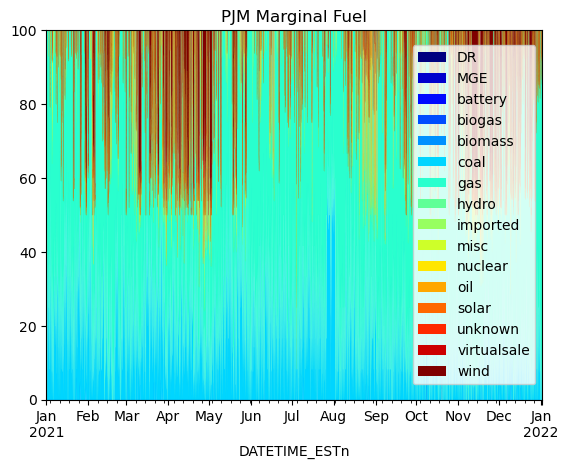

In [8]:
# plotting 2021 marginal fuel mix
f1 = plt.figure()

plt.title('PJM Marginal Fuel', color='black')
df.loc['2021-01-01':'2022-01-01'].plot(kind='area', ax=f1.gca(), colormap='jet', linewidth=0.01)
plt.legend(loc='right', bbox_to_anchor=(1.0, 0.5))
plt.ylim([0,100])
plt.show()

# ax1 = df.loc['2021-01-01':'2022-01-01'].plot.area(colormap='jet')
# ax1.yaxis.label.set_visible(False) # disable y-axis label
# # add the legend
# ax1.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
# plt.show()


In [23]:
# Group by Quarter 

df2 = df.groupby(pd.PeriodIndex(df.reset_index()['DATETIME_ESTn'], freq="Q")).mean()
# df2 = df.groupby([(df.index.year), (df.index.month)]).mean()
mux = pd.MultiIndex.from_arrays([df2.index.year, df2.index.quarter], names=['year','quarter'])
mux
df2.index = mux


datestart = '2003-12-31'
dateend = '2023-12-31'

df2 = df2.loc[datestart:dateend]
df2['unknown'] = 100 - df2.drop('unknown', axis=1).sum(axis=1)
df2


FUEL                DR  MGE  battery    biogas   biomass       coal  \
year quarter                                                          
2004 1        0.000000  0.0      0.0  0.000000  0.000000  52.269281   
     2        0.000000  0.0      0.0  0.000000  0.000000  52.508393   
     3        0.000000  0.0      0.0  0.000000  0.000000  59.181880   
     4        0.000000  0.0      0.0  0.000000  0.000000  63.767255   
2005 1        0.000000  0.0      0.0  0.000000  0.000000  72.442824   
...                ...  ...      ...       ...       ...        ...   
2021 3        0.000000  0.0      0.0  0.012604  0.014534  21.153551   
     4        0.008700  0.0      0.0  0.027550  0.048392  11.507149   
2022 1        0.004611  0.0      0.0  0.004801  0.032472  18.448551   
     2        0.023347  0.0      0.0  0.014853  0.061442  11.108246   
     3        0.031155  0.0      0.0  0.025827  0.011436  13.484132   

FUEL                gas  hydro  imported      misc   nuclear       oil  \
year quarter                                                             
2004 1        38.525705    0.0  0.915755  0.000000  0.000000  6.820216   
     2        31.671506    0.0  2.739629  0.000000  0.000000  9.861695   
     3        30.146150    0.0  3.291789  0.000000  0.000000  4.531917   
     4        24.591096    0.0  6.199135  0.000000  0.000000  4.642733   
2005 1        16.154519    0.0  1.566292  0.019931  0.000000  7.998490   
...                 ...    ...       ...       ...       ...       ...   
2021 3        72.801268    0.0  0.000000  0.035091  0.854665  2.241769   
     4        69.316119    0.0  0.000000  0.050824  1.801087  1.457124   
2022 1        58.974574    0.0  0.000000  0.109185  0.594481  6.086778   
     2        70.822972    0.0  0.000000  0.058608  0.925018  0.374265   
     3        81.184159    0.0  0.000000  0.059823  0.125319  1.571556   

FUEL             solar   unknown  virtualsale       wind  
year quarter                                              
2004 1        0.000000  1.469042          0.0   0.000000  
     2        0.000000  3.218777          0.0   0.000000  
     3        0.000000  2.843862          0.0   0.004402  
     4        0.000000  0.797262          0.0   0.002518  
2005 1        0.000000  1.817945          0.0   0.000000  
...                ...       ...          ...        ...  
2021 3        0.340462  0.155229          0.0   2.390829  
     4        0.106852  0.531547          0.0  15.144656  
2022 1        0.609870  2.289602          0.0  12.845074  
     2        1.993333  0.252424          0.0  14.365490  
     3        0.623507  0.249087          0.0   2.633996  

[75 rows x 16 columns]

In [20]:
cdf = pd.read_csv('colormap_byfuel.csv', header=None, index_col=[0])
for index, row in cdf.transpose().iterrows():
    cmapdict = row.to_dict()
    print(cmapdict)

{'DR': 'azure', 'MGE': 'gainsboro', 'battery': 'green', 'biogas': 'darkseagreen', 'biomass': 'lightgreen', 'coal': 'black', 'gas': 'red', 'hydro': 'lightskyblue', 'imported': 'lightgrey', 'misc': 'lightsalmon', 'nuclear': 'peru', 'oil': 'orangered', 'solar': 'yellow', 'unknown': 'lightgrey', 'virtualsale': 'lightgrey', 'wind': 'blue'}


In [21]:
cmapdict[tech]

'azure'

In [26]:
xlabels = [list(df2.index.get_level_values(0)),
           list(df2.index.get_level_values(1)),
           df2.index]

fig = go.Figure()

# create traces
for idx, tech in enumerate(df2.columns):
    fig.add_trace(
        go.Bar(
            y=df2[tech],
            x=xlabels,
            name=tech,
            showlegend=True,
            width=1.0,
            hovertemplate= f"%{{x}}Q, %{{y:.1f}}%", 
            hoverinfo ='name+x+y',
            marker = dict(color = cmapdict[tech])
            # marker=dict(colors=cmapdict[tech])
        )
    )

# specify layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    yaxis=dict(
        titlefont_size=12,
        tickfont_size=10,
        title="% of marginal fuel",
        showspikes=True),
    xaxis=dict(
        titlefont_size=12,
        tickfont_size=10),
    title_text='PJM Marginal Fuel Mix by Quarter',
    template='simple_white',
    barmode='stack'
)

fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="bottom",
            y=0.02,
            xanchor="left",
            x=1
        ),
        yaxis=dict(
            range=[0, 100]
        )
    )

fig.show()

In [ ]:
df2.columns.to_list()

In [ ]:
df2

In [ ]:
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

In [ ]:
mux = pd.MultiIndex.from_arrays([df2.index.year, df2.index.month], names=['year','month'])
mux
df2.index = mux
df2

In [ ]:
df2

In [ ]:
# plotting 2004-2022 marginal fuel mix averaged by month
f2 = plt.figure()

datestart = '2004-01-01'
dateend = '2022-01-01'

plt.title('PJM Marginal Fuel', color='black')
# df.loc[datestart:dateend].groupby(pd.PeriodIndex(df.loc[datestart:dateend].reset_index()['DATETIME_UTC'], freq="M")).mean().plot(kind='bar', stacked=True, 
#     ax=f2.gca(), colormap='jet', linewidth=0.01, width=1.0)
df2.loc[datestart:dateend].plot(kind='bar', stacked=True, 
    ax=f2.gca(), colormap='jet', linewidth=0.01, width=1.0)
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.6))
plt.ylim([0,100])
plt.show()




# df.plot.area(colormap='jet')

In [ ]:
list(df2.index.get_level_values(0))

In [ ]:
df.loc['2021-01-01':'2022-01-01']['wind'].plot(ylim=[0,1], title="%WIND on the margin")

In [ ]:
fueltypesSeries = pd.Series(margfueldf['FUEL'].unique())
fueltypesSeries.to_csv('fueltypes.csv')

In [ ]:
pd.Series(margfueldf['FUEL'].unique())

In [ ]:
margfueldf[margfueldf['FUEL']=='nan']

In [ ]:
margfueldf[margfueldf['FUEL']=='Min Gen/Dispatch Reset']